In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/'

/content/drive/MyDrive


In [3]:
import tensorflow as tf 
import numpy as np
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization,MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os

In [10]:
class ConvBlock(tf.keras.Model):
    def __init__(self, filters, kernel, strides, padding):
       
        super(ConvBlock, self).__init__()
        self.cnn = tf.keras.layers.Conv2D(filters, (kernel, kernel), 
                                          strides=(strides, strides), 
                                          kernel_initializer='he_normal', 
                                          padding=padding)
        
        
        self.pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2),strides=(1, 1))
        
        self.bn = tf.keras.layers.BatchNormalization()
 
    def call(self, inputs):
        x = None
        
        x = self.cnn(inputs)
        x = self.bn(x)
        x = tf.nn.relu(x)   
        x = self.pool(x)
        return x

In [12]:
class CNN(tf.keras.Model):
    def __init__(self, num_classes):
        
        super(CNN, self).__init__()
        
        self.block1 = ConvBlock(64, kernel=3, strides=1, padding='same')
        self.block2 = ConvBlock(128, kernel=3, strides=1, padding='same')
        self.block3 = ConvBlock(256, kernel=3, strides=1, padding='same')
        self.block4 = ConvBlock(512, kernel=3, strides=1, padding='same')
        self.block5 = ConvBlock(512, kernel=3, strides=1, padding='same')       
        self.block6 = ConvBlock(1024, kernel=3, strides=1, padding='same')
        self.dropout = tf.keras.layers.Dropout(rate=0.2)
        
        self.flatten = tf.keras.layers.Flatten()
        
      
        self.dense1 = tf.keras.layers.Dense(num_classes)
        


    def call(self, inputs):
        
        
       
        x = self.block1(inputs)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        
        x = self.flatten(x)
        x = self.dropout(x)
        
       
        x = self.dense1(x)
        
        output = tf.nn.softmax(x)

        return output

In [35]:
height = 150
weight = 150
batch_size = 64
data_dir = 'Animals-10'

In [ ]:
class_names = os.listdir(data_dir) # Get names of classes
class_name2id = { label: index for index, label in enumerate(class_names) } # Map class names to integer labels

In [ ]:
data_images=[]
data_image_labels=[]

for folder in os.listdir(data_dir):
    image_list=os.listdir(data_dir+"/"+folder)
    for img_name in image_list:
        # Loading images
        image_path = data_dir+"/"+folder+"/"+img_name
        # Converting to arrarys
        image = Image.open(image_path).convert("RGB").resize((224,224))
       
        image_array = np.array(image).astype('float32')/255
        # Appending arrays
        data_images.append(image_array) # appending image array
        data_image_labels.append(class_name2id[folder])
        if len(data_images)%100 ==0:
          print(len(data_images))
        
print("Preparing Validation Dataset Completed.")

In [36]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [37]:
train_gen = data_gen.flow_from_directory(
    data_dir,
    target_size = (height, weight),
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = True,
    subset = 'training',
    seed = 123
)
valid_gen = data_gen.flow_from_directory(
    data_dir,
    target_size = (height, weight),
    class_mode = 'categorical',
    batch_size = batch_size,
    subset = 'validation',
    seed = 123
)

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


In [15]:
device = '/gpu:0'
epochs = 25

# Số lượng training step mỗi epoch
steps_per_epoch = train_gen.n // batch_size
# Số lượng validation step
validation_steps = valid_gen.n // batch_size

with tf.device(device):
    # Khởi tạo model
    model = CNN(num_classes=10)
    
    
    mcp = tf.keras.callbacks.ModelCheckpoint("cnn_animal.h5", monitor="val_accuracy",
                      save_best_only=True, save_weights_only=True)
    
    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    

    model.fit(train_gen, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=epochs,
                        verbose=1, 
                        validation_data=valid_gen,
                        validation_steps=validation_steps, 
                        callbacks=[mcp])

Epoch 1/25
327/327 [==============================] - 4346s 13s/step - loss: 2.3003 - accuracy: 0.3484 - val_loss: 2.7667 - val_accuracy: 0.2473
Epoch 2/25
327/327 [==============================] - 339s 1s/step - loss: 1.6084 - accuracy: 0.5035 - val_loss: 2.2856 - val_accuracy: 0.3522
Epoch 3/25
327/327 [==============================] - 339s 1s/step - loss: 1.2454 - accuracy: 0.5900 - val_loss: 1.4679 - val_accuracy: 0.5176
Epoch 4/25
327/327 [==============================] - 339s 1s/step - loss: 1.0332 - accuracy: 0.6499 - val_loss: 1.2269 - val_accuracy: 0.5841
Epoch 5/25
327/327 [==============================] - 338s 1s/step - loss: 0.9207 - accuracy: 0.6855 - val_loss: 1.5619 - val_accuracy: 0.4931
Epoch 6/25
327/327 [==============================] - 338s 1s/step - loss: 0.8142 - accuracy: 0.7253 - val_loss: 1.0203 - val_accuracy: 0.6593
Epoch 7/25
327/327 [==============================] - 338s 1s/step - loss: 0.7332 - accuracy: 0.7554 - val_loss: 0.9103 - val_accuracy: 0.69

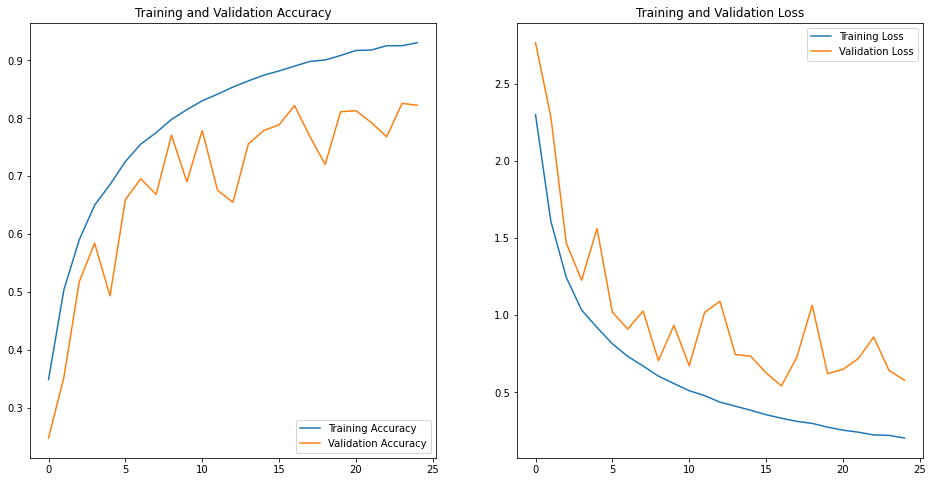

In [16]:
history = model.history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
from keras.layers import MaxPooling2D

In [42]:
model = Sequential()
model.add(Conv2D(32,(3,3), strides =(1,1),activation='relu', kernel_initializer='he_normal', padding = 'same', input_shape=(150,150,3)))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=(3,3), strides =(1,1),activation='relu',kernel_initializer='he_normal', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64,kernel_size=(3,3),strides =(1,1),activation='relu',kernel_initializer='he_normal', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=(3,3), strides =(1,1),activation='relu', kernel_initializer='he_normal', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128,kernel_size=(3,3), strides =(1,1),activation='relu', kernel_initializer='he_normal', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(128,kernel_size=(3,3), strides =(1,1),activation='relu', kernel_initializer='he_normal', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256,kernel_size=(3,3), strides =(1,1),activation='relu', kernel_initializer='he_normal', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(256,kernel_size=(3,3), strides =(1,1),activation='relu', kernel_initializer='he_normal', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Flatten())

model.add(Dense(128,kernel_initializer='he_normal',activation ='relu', kernel_regularizer='l2' ))
model.add(Dropout(0.2))
model.add(Dense(128,kernel_initializer='he_normal',activation ='relu', kernel_regularizer='l2' ))
model.add(Dropout(0.2))
model.add(Dense(10,kernel_initializer='he_normal',activation ='softmax' ))

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization_44 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_45 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
batch_normalization_46 (Batc (None, 75, 75, 64)      

In [43]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics=['accuracy'])
mcp = tf.keras.callbacks.ModelCheckpoint("cnn_animal_01.h5", monitor="val_accuracy",
                                          save_best_only=True, save_weights_only=True)

In [44]:
model.fit(train_gen,steps_per_epoch=steps_per_epoch, 
                    epochs=epochs,verbose=1, 
                    validation_data=valid_gen,
                    validation_steps=validation_steps, 
                    callbacks=[mcp])

Epoch 1/25
327/327 [==============================] - 202s 610ms/step - loss: 6.7234 - accuracy: 0.1951 - val_loss: 3.1128 - val_accuracy: 0.2236
Epoch 2/25
327/327 [==============================] - 198s 607ms/step - loss: 2.8616 - accuracy: 0.2754 - val_loss: 2.3586 - val_accuracy: 0.3573
Epoch 3/25
327/327 [==============================] - 199s 610ms/step - loss: 2.2856 - accuracy: 0.3843 - val_loss: 2.2895 - val_accuracy: 0.3835
Epoch 4/25
327/327 [==============================] - 197s 602ms/step - loss: 1.9771 - accuracy: 0.4616 - val_loss: 7.5729 - val_accuracy: 0.1055
Epoch 5/25
327/327 [==============================] - 200s 611ms/step - loss: 1.7644 - accuracy: 0.5319 - val_loss: 1.8359 - val_accuracy: 0.5066
Epoch 6/25
327/327 [==============================] - 196s 601ms/step - loss: 1.6226 - accuracy: 0.5831 - val_loss: 1.7884 - val_accuracy: 0.5384
Epoch 7/25
327/327 [==============================] - 199s 611ms/step - loss: 1.5352 - accuracy: 0.6243 - val_loss: 1.9815 -

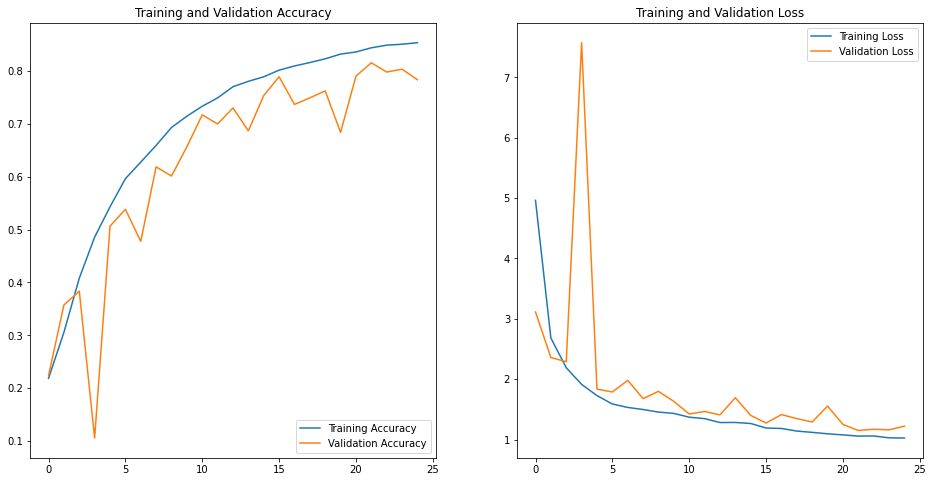

In [45]:
history = model.history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
device = '/gpu:0'
# Số lượng training step mỗi epoch
steps_per_epoch = train_gen.n // batch_size
# Số lượng validation step
validation_steps = valid_gen.n // batch_size
with tf.device(device):
    # Khởi tạo base model Resnet với pretrained weights từ ImageNet
    base_model = tf.keras.applications.ResNet50(input_shape=(224,224,3),
                                               include_top=False, 
                                               weights='imagenet')
    
    # Tạo model hoàn chỉnh bằng cách thêm lớp classifier
    model = tf.keras.Sequential([
      base_model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    # Freeze các lớp CNN ban đầu
    base_model.trainable = False
    
    # Tạo callback để lưu model có accuracy trên tập validation tốt nhất
    mcp = tf.keras.callbacks.ModelCheckpoint("resnet50_animal.h5", monitor="val_accuracy",
                      save_best_only=True, save_weights_only=True)
    rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, mode='max', 
                                               patience=5, min_lr=1e-8, verbose=1)
    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Huấn luyện 10 epochs với learning rate lớn
    model.fit(train_gen, 
              steps_per_epoch=steps_per_epoch, 
              epochs=10,
              verbose=1, 
              validation_data=valid_gen,
              validation_steps=validation_steps, 
              callbacks=[mcp,rlr])
    
    # Unfreeze toàn bộ mạng
    base_model.trainable = True
    
    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Huấn luyện với learning rate nhỏ
    model.fit(train_gen, 
              steps_per_epoch=steps_per_epoch, 
              epochs=30,
              verbose=1, 
              validation_data=valid_gen,
              validation_steps=validation_steps, 
              callbacks=[mcp])

327/327 [==============================] - ETA: 0s - loss: 2.1815 - accuracy: 0.2344 

In [ ]:
history = model.history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()